# Study of the entropia on the entire model

In [19]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from training_bert import BertNliLight
from regularize_training_bert import SNLIDataModule
from regularize_training_bert import BertNliRegu
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [2]:
ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## The data

In [3]:
data_dir = os.path.join(".cache", "raw_data", "e_snli")

dm = SNLIDataModule(cache=data_dir,
                   batch_size = 1,
                   num_workers = 4,
                   nb_data = 999 # multiple of three for the consistency
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

## The entropia for each head of each layer

In [8]:
mean_calculus = np.zeros((12, 12))
softmax_calculus = np.zeros((12, 12))
mean_softmax_calculus = np.zeros((12, 12))

with torch.no_grad():
    for id_batch, batch in tqdm(enumerate(test_dataloader)):

        ids = batch["input_ids"]
        mk = batch["attention_masks"]
        labels = batch["labels"]
        a_true = batch["annotations"]

        spe_tok_mask = torch.isin(ids, torch.tensor([0, 101, 102])).type(torch.uint8)[0]

        # creation of the attention_mask
        raw_attention_inst = RawAttention(model = model,
                                             input_ids = ids,
                                             attention_mask = mk,
                                             test_mod = False
                                             )

        for l in range(12):
            for h in range(12):
                # softmax calculus
                a_hat = raw_attention_inst.attention_tensor[0, l, h, :, :].sum(dim=0)
                a_hat = torch.softmax(a_hat - INF * spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
                softmax_calculus[l,h] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()
                
                # mean calculus
                a_hat = raw_attention_inst.attention_tensor[0, l, h, :, :].sum(dim=0)/len(raw_attention_inst.tokens)
                mean_calculus[l,h] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()
                
                # mean + softmax
                a_hat = raw_attention_inst.attention_tensor[0, l, h, :, :].sum(dim=0)/len(raw_attention_inst.tokens)
                a_hat = torch.softmax(a_hat - INF * spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
                mean_softmax_calculus[l,h] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()

999it [04:04,  4.09it/s]


In [11]:
from attention_algorithms.attention_metrics import default_plot_colormap

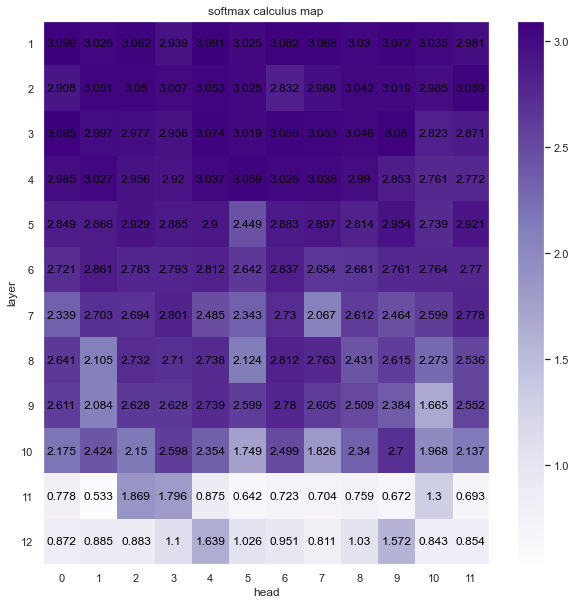

In [33]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999, 
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_map.png"))

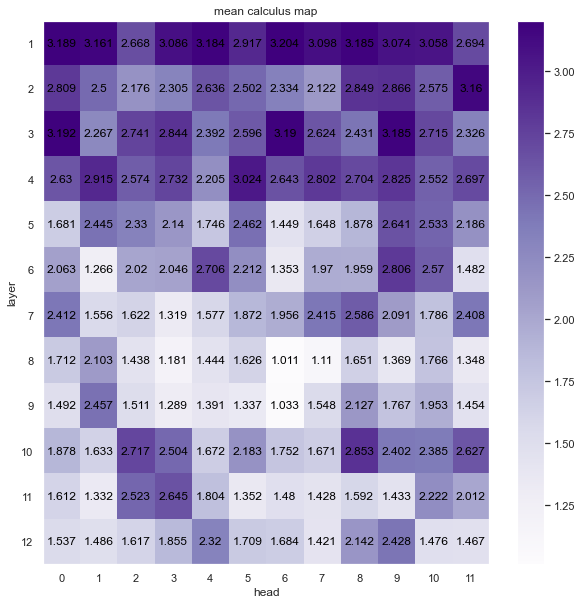

In [34]:
mean_fig = default_plot_colormap(map = mean_calculus/999, 
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "mean calculus map")
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_entropy_map.png"))

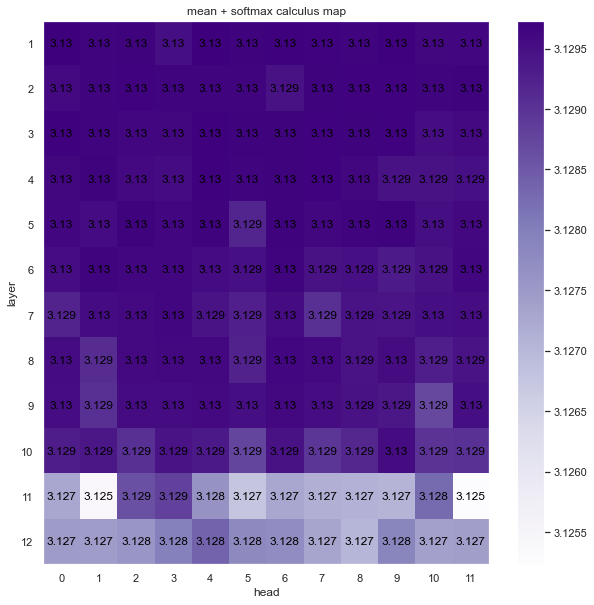

In [35]:
softmax_mean_fig = default_plot_colormap(map = mean_softmax_calculus/999, 
                                         xlabel = "head",
                                         ylabel = "layer",
                                         title = "mean + softmax calculus map")
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_softmax_entropy_map.png"))

## Study of the 2 part of the model

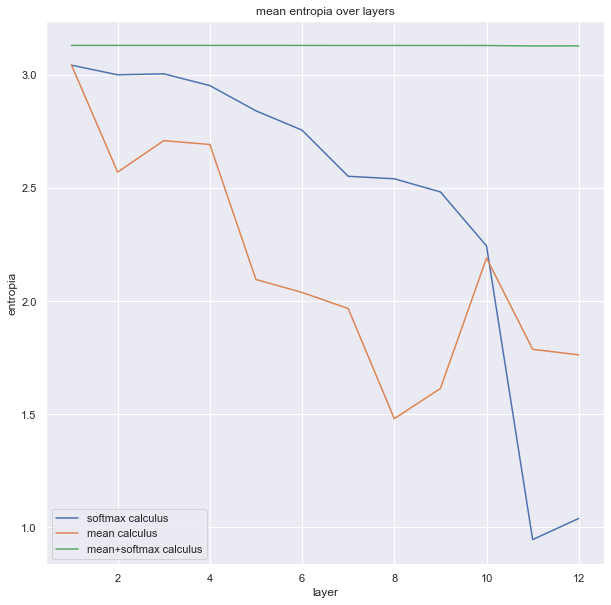

In [32]:
fig = plt.figure(figsize=(10,10))

txt = plt.title("mean entropia over layers")

plt.plot(list(range(1,13)), np.sum(softmax_calculus/999, axis=-1)/12, label="softmax calculus")
plt.plot(list(range(1,13)), np.sum(mean_calculus/999, axis=-1)/12, label="mean calculus")
plt.plot(list(range(1,13)), np.sum(mean_softmax_calculus/999, axis=-1)/12, label="mean+softmax calculus")

plt.ylabel("entropia")
plt.xlabel("layer")

txt = plt.legend()

## The entropia by agregation of the heads on each layers

In [36]:
mean_calculus = np.zeros((12, 1))
softmax_calculus = np.zeros((12, 1))
mean_softmax_calculus = np.zeros((12, 1))

with torch.no_grad():
    for id_batch, batch in tqdm(enumerate(test_dataloader)):

        ids = batch["input_ids"]
        mk = batch["attention_masks"]
        labels = batch["labels"]
        a_true = batch["annotations"]

        spe_tok_mask = torch.isin(ids, torch.tensor([0, 101, 102])).type(torch.uint8)[0]

        # creation of the attention_mask
        raw_attention_inst = RawAttention(model = model,
                                             input_ids = ids,
                                             attention_mask = mk,
                                             test_mod = False
                                             )

        for l in range(12):
            # softmax calculus
            a_hat = raw_attention_inst.attention_tensor[0, l, :, :, :].sum(dim=0).sum(dim=0)
            a_hat = torch.softmax(a_hat - INF * spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
            softmax_calculus[l,0] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()

            # mean calculus
            a_hat = raw_attention_inst.attention_tensor[0, l, :, :, :].sum(dim=1)/len(raw_attention_inst.tokens)
            a_hat = a_hat.sum(dim=0)/12 # mean over the heads
            a_hat = torch.mul(a_hat, spe_tok_mask[0:len(raw_attention_inst.tokens)])
            mean_calculus[l,0] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()

            # mean + softmax
            a_hat = raw_attention_inst.attention_tensor[0, l, :, :, :].sum(dim=1)/len(raw_attention_inst.tokens) # mean over the lines
            a_hat = a_hat.sum(dim=0)/12 # mean over the heads
            a_hat = torch.mul(a_hat, spe_tok_mask[0:len(raw_attention_inst.tokens)])
            a_hat = torch.softmax(a_hat - INF * spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
            mean_softmax_calculus[l,0] += (-a_hat * torch.log(a_hat + 1e-16)).sum().item()

999it [03:30,  4.74it/s]


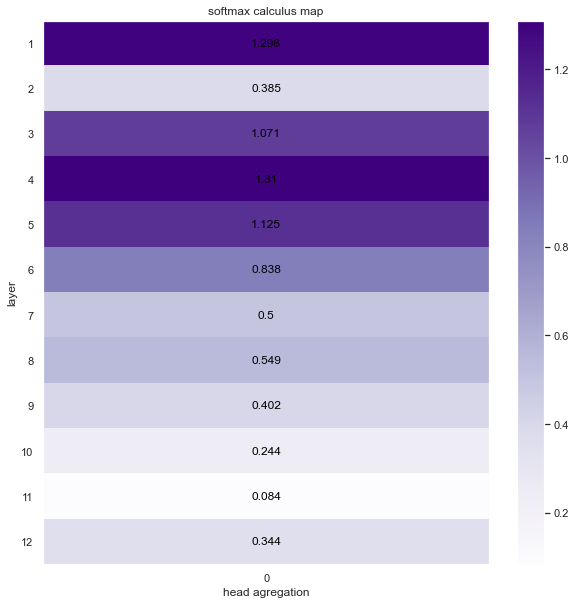

In [40]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999, 
                                    xlabel = "head agregation",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_map_layer.png"))

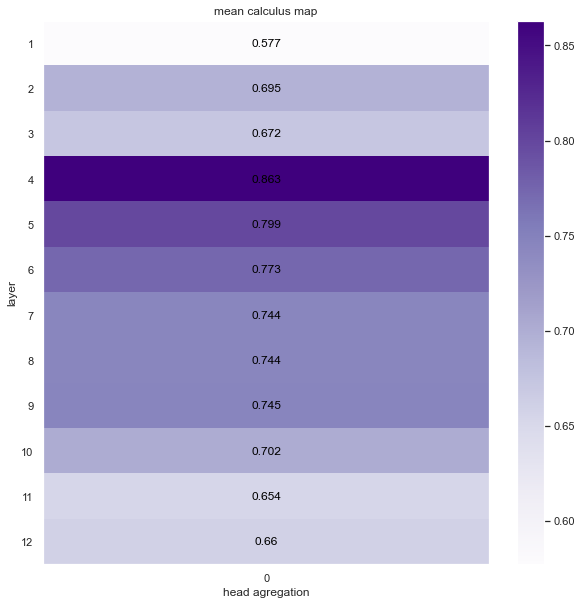

In [41]:
mean_fig = default_plot_colormap(map = mean_calculus/999, 
                                xlabel = "head agregation",
                                ylabel = "layer",
                                title = "mean calculus map"
                                )

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_entropy_map_layer.png"))

strange behaviour for this one

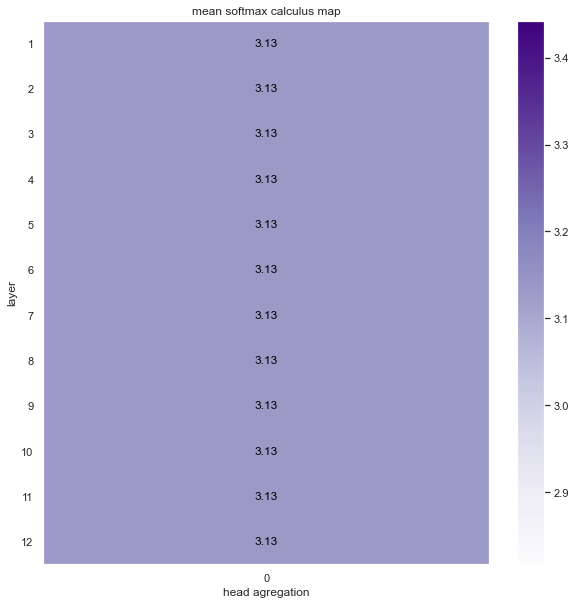

In [43]:
mean_softmax_fig = default_plot_colormap(map = mean_softmax_calculus/999, 
                                    xlabel = "head agregation",
                                    ylabel = "layer",
                                    title = "mean softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_softmax_entropy_map_layer.png"))